In [14]:
# This is how the data is retrieved from the Materials Project API

# import os
# import dotenv

# dotenv.load_dotenv()
# MP_API_KEY = os.getenv("MP_API_KEY")

# from mp_api.client import MPRester
# from emmet.core.summary import HasProps

# with MPRester(MP_API_KEY) as mpr:
#     docs = mpr.summary.search(
#         has_props = [HasProps.dielectric], fields=['material_id', 'band_gap', 'builder_meta', 'nsites', 'elements', 'nelements', 'composition', 'composition_reduced', 'formula_pretty', 'formula_anonymous', 'chemsys', 'volume', 'density', 'density_atomic', 'symmetry', 'property_name', 'deprecated', 'deprecation_reasons', 'last_updated', 'origins', 'warnings', 'structure', 'task_ids', 'uncorrected_energy_per_atom', 'energy_per_atom', 'formation_energy_per_atom', 'energy_above_hull', 'is_stable', 'equilibrium_reaction_energy_per_atom', 'decomposes_to', 'xas', 'grain_boundaries', 'cbm', 'vbm', 'efermi', 'is_gap_direct', 'is_metal', 'es_source_calc_id', 'bandstructure', 'dos', 'dos_energy_up', 'dos_energy_down', 'is_magnetic', 'ordering', 'total_magnetization', 'total_magnetization_normalized_vol', 'total_magnetization_normalized_formula_units', 'num_magnetic_sites', 'num_unique_magnetic_sites', 'types_of_magnetic_species', 'k_voigt', 'k_reuss', 'k_vrh', 'g_voigt', 'g_reuss', 'g_vrh', 'universal_anisotropy', 'homogeneous_poisson', 'e_total', 'e_ionic', 'e_electronic', 'n', 'e_ij_max', 'weighted_surface_energy_EV_PER_ANG2', 'weighted_surface_energy', 'weighted_work_function', 'surface_anisotropy', 'shape_factor', 'has_reconstructed', 'possible_species', 'has_props', 'theoretical', 'database_IDs']
#     )
#     mpids = [doc.material_id for doc in docs]
# from emmet.core.utils import jsanitize
# from monty.serialization import dumpfn, loadfn

# sanitized_docs = jsanitize(docs)
# dumpfn(sanitized_docs, "master_query_doc.json.gz")


/Users/chuk/.pyenv/versions/sci/lib/python3.11/site-packages/mp_api/client/mprester.py:227: UserWarning: mpcontribs-client not installed. Install the package to query MPContribs data, or construct pourbaix diagrams: 'pip install mpcontribs-client'
  warnings.warn(
/var/folders/0g/5jf3qwcs019bg13rfsqbdhvh0000gn/T/ipykernel_428/613411296.py:2: DeprecationWarning: Accessing summary data through MPRester.summary is deprecated. Please use MPRester.materials.summary instead.
  docs = mpr.summary.search(


Retrieving SummaryDoc documents:   0%|          | 0/7290 [00:00<?, ?it/s]

In [236]:
import pandas as pd
from monty.serialization import loadfn

data = loadfn("master_query_doc.json.gz")    


In [237]:
df = pd.DataFrame(data)
df.head()
# unpack the "symmetry" data. Note there are probably other columns that need to be unpacked, but for now only handling this case
df[['crystal_system', 'symbol', 'number', 'point_group', 'symprec', 'version']] = df['symmetry'].apply(lambda x: pd.Series(x))

df = df.drop(columns=['version', 'symprec'])


In [238]:
# somewhat arbitrarily, include materials that have e_ij_max values
df_numeric = df.select_dtypes(include='number')[df['e_ij_max'].notna()]
# drop columns that have more than 10% NaN values
df_numeric = df_numeric.dropna(how="any", axis=1)


# drop feature columns with correlation greater than 0.90
corr_matrix = df_numeric.corr().abs()
# select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]
df_numeric = df_numeric.drop(to_drop, axis=1)

corr_matrix.style.background_gradient(cmap='coolwarm', axis=None)


,nsites,nelements,volume,density,density_atomic,uncorrected_energy_per_atom,energy_per_atom,formation_energy_per_atom,energy_above_hull,band_gap,efermi,total_magnetization,total_magnetization_normalized_vol,total_magnetization_normalized_formula_units,num_magnetic_sites,num_unique_magnetic_sites,e_total,e_ionic,e_electronic,n,e_ij_max,number
nsites,1.000000,0.312247,0.800054,0.220858,0.249719,0.183768,0.192564,0.221613,0.043849,0.206253,0.161545,0.140658,0.004191,0.046086,0.197650,0.064284,0.020754,0.022545,0.020260,0.073018,0.052888,0.097677
nelements,0.312247,1.000000,0.161487,0.135255,0.269875,0.213495,0.233779,0.301439,0.029545,0.085790,0.078050,0.099815,0.071281,0.128694,0.130745,0.089298,0.030326,0.024514,0.031507,0.087744,0.003222,0.159684
volume,0.800054,0.161487,1.000000,0.119654,0.248155,0.099212,0.095492,0.030179,0.078021,0.039071,0.118675,0.056633,0.079861,0.024781,0.070060,0.005594,0.019468,0.024035,0.018353,0.038584,0.080125,0.006751
density,0.220858,0.135255,0.119654,1.000000,0.176702,0.085506,0.073328,0.074648,0.075312,0.415526,0.583916,0.066795,0.055026,0.061637,0.074236,0.071229,0.044067,0.066689,0.038770,0.166422,0.095244,0.208590
density_atomic,0.249719,0.269875,0.248155,0.176702,1.000000,0.584544,0.597234,0.413707,0.054719,0.318630,0.053370,0.133120,0.179207,0.136452,0.195918,0.140625,0.001918,0.006009,0.003699,0.069698,0.071034,0.187249
uncorrected_energy_per_atom,0.183768,0.213495,0.099212,0.085506,0.584544,1.000000,0.991434,0.583757,0.020091,0.248331,0.153959,0.125215,0.128269,0.121412,0.152447,0.096486,0.027495,0.045327,0.023351,0.013188,0.088186,0.080593
energy_per_atom,0.192564,0.233779,0.095492,0.073328,0.597234,0.991434,1.000000,0.622144,0.025063,0.237277,0.114182,0.171956,0.185164,0.169598,0.213580,0.150820,0.021916,0.041431,0.017416,0.027770,0.091495,0.109056
formation_energy_per_atom,0.221613,0.301439,0.030179,0.074648,0.413707,0.583757,0.622144,1.000000,0.170294,0.422413,0.225782,0.124610,0.118645,0.110003,0.158154,0.112340,0.020619,0.002468,0.024627,0.133543,0.055677,0.152126
energy_above_hull,0.043849,0.029545,0.078021,0.075312,0.054719,0.020091,0.025063,0.170294,1.000000,0.019564,0.034931,0.055303,0.091370,0.082643,0.070351,0.078681,0.004307,0.003800,0.004403,0.002847,0.039501,0.038027
band_gap,0.206253,0.085790,0.039071,0.415526,0.318630,0.248331,0.237277,0.422413,0.019564,1.000000,0.500400,0.171081,0.208079,0.207021,0.216550,0.230555,0.034752,0.042273,0.032904,0.179106,0.045331,0.072335


In [239]:
# retrive categorical labels of the data 

df_categorical = df.iloc[df_numeric.index].select_dtypes(include=['object'])
df_categorical = df_categorical[['formula_anonymous', 'chemsys', 'ordering', 'crystal_system', 'symbol', 'point_group']]


In [240]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks


In [241]:
materials = pd.merge(df_numeric, df_categorical, left_index=True, right_index=True)

X = materials
y = materials.pop('band_gap')  # target property
y = y / np.max(y)


# groupings that should not be split across train/valid
formulas = df.iloc[materials.index].formula_pretty


preprocessor = make_column_transformer(
    (StandardScaler(),
     make_column_selector(dtype_include=np.number)),
    (OneHotEncoder(sparse_output=False),
     make_column_selector(dtype_include=object)),
)

X = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))


Input shape: [2902]


In [242]:
X.shape


(3301, 2902)

In [248]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model = keras.Sequential([
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dropout(rate=0.1),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(512, activation='swish'),
    layers.Dense(1),
])
model.compile(
    optimizer='adam',
    loss='mae',
)


In [249]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=256,
    epochs=750,
    callbacks=[early_stopping],
)


Epoch 1/750
9/9 [==============================] - 1s 24ms/step - loss: 0.5637 - val_loss: 0.2451
Epoch 2/750
9/9 [==============================] - 0s 13ms/step - loss: 0.5155 - val_loss: 0.2646
Epoch 3/750
9/9 [==============================] - 0s 10ms/step - loss: 0.3944 - val_loss: 0.2506
Epoch 4/750
9/9 [==============================] - 0s 11ms/step - loss: 0.3277 - val_loss: 0.2456
Epoch 5/750
9/9 [==============================] - 0s 11ms/step - loss: 0.2852 - val_loss: 0.2378
Epoch 6/750
9/9 [==============================] - 0s 11ms/step - loss: 0.2485 - val_loss: 0.2515
Epoch 7/750
9/9 [==============================] - 0s 11ms/step - loss: 0.2300 - val_loss: 0.2212
Epoch 8/750
9/9 [==============================] - 0s 11ms/step - loss: 0.2231 - val_loss: 0.1971
Epoch 9/750
9/9 [==============================] - 0s 10ms/step - loss: 0.2029 - val_loss: 0.2479
Epoch 10/750
9/9 [==============================] - 0s 12ms/step - loss: 0.1930 - val_loss: 0.2032
Epoch 11/750
9/9 [=

Minimum validation loss: 0.09695395827293396


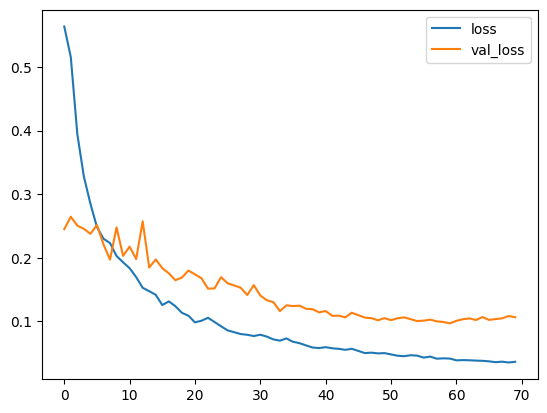

In [250]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))


35/35 [==============================] - 0s 1ms/step


Text(0.5, 1.0, 'MAE: 1089.707 eV')

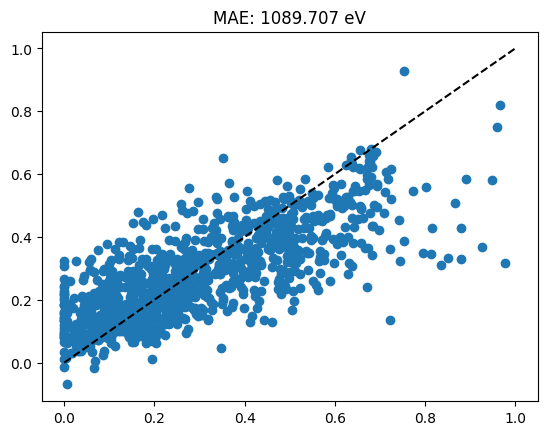

In [ ]:
y_predict = model.predict(X_test)

plt.scatter(y_test, y_predict)
plt.plot([0, 1], [0, 1], '--k')
mae = np.mean(np.abs(y_predict.reshape(-1).shape - y_test))/len(y_test)
plt.title("MAE: {:.3f} eV".format(mae))
